In [1]:
#|default_exp refactor

In [2]:
#| echo: false
#| export
from fastai.basics import *
from fastai.vision.models.unet import *
from fastai.vision.all import *
from fastai.torch_basics import *
from denoising_diffusion_pytorch import Unet
from fastai.callback.wandb import _make_plt
from torch import autocast
from fastcore.transform import _is_tuple
from fastai.vision.gan import InvisibleTensor,generate_noise

In [3]:
#| echo: false
#| export
def del_if_exists(to_del='',delim=','):
    for n in to_del.split(delim): 
        if n in globals(): del globals()[n]

Add explanation of why subclassing TensorImageBase, and what is TypeDispatch. (title needs to be full name)

We create two new Tensor Types, one for our noise, and one for our timestep. 

In [4]:
#| export
class TensorNoise(TensorImageBase):pass
class TensorStep(TensorBase): pass

We would like normalize to denormalize our noise before showing it. This is so the noise in our image looks similar to the noise in our noised image. 

In [5]:
#| export
@Normalize
def decodes(self, x:TensorNoise):
    f = to_cpu if x.device.type=='cpu' else noop
    return (x*f(self.std) + f(self.mean))

In [6]:
#| echo: false
path = untar_data(URLs.IMAGENETTE_320)
img = Image.open(path.ls()[0].ls()[3].ls()[0])
norm = Normalize.from_stats(*imagenet_stats)
img = norm(TensorImage(image2tensor(img)[None]/255.).to(device='cuda'))

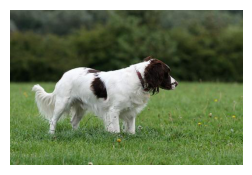

In [7]:
norm = Normalize.from_stats(*imagenet_stats)
show_images(norm.decode(img))

I patch ItemTransform here, so that it can work off of TypedTuples. Essentially if we have a `DiffusionTuple`, the transform will apply to that if it should apply to that type of tuple. 

In [8]:
class ItemTransform(Transform):
    "A transform that always take tuples as items"
    _retain = True
    # Only showing important code
    def _call1(self:ItemTransform, x, name, **kwargs):
        if not _is_tuple(x): return getattr(super(), name)(x, **kwargs)
        y=self._call_tuple(name,x,**kwargs)
        if not self._retain: return y
        if is_listy(y) and not isinstance(y, tuple): y = tuple(y)
        return retain_type(y, x)
    def _call_tuple(self:ItemTransform, name, x, split_idx=None, **kwargs):
        f = getattr(super(), name)
        f2name='encodes' if name == '__call__' else 'decodes' if name == 'decode' else name
        f2 = getattr(self, f2name)
        if isinstance(f2,TypeDispatch) and f2[type(x)] is not None:
            if split_idx!=self.split_idx and self.split_idx is not None: return x
            y = f2(x, **kwargs)
        else:
            y = f(list(x), **kwargs)
        return y

In [9]:
#| export
#| echo: false
class ItemTransform(Transform):
    "A transform that always take tuples as items"
    _retain = True
    def __call__(self, x, **kwargs): return self._call1(x, '__call__', **kwargs)
    def decode(self, x, **kwargs):   return self._call1(x, 'decode', **kwargs)
    def _call1(self:ItemTransform, x, name, **kwargs):
        if not _is_tuple(x): return getattr(super(), name)(x, **kwargs)
        y=self._call_tuple(name,x,**kwargs)
        if not self._retain: return y
        if is_listy(y) and not isinstance(y, tuple): y = tuple(y)
        return retain_type(y, x)
    def _call_tuple(self:ItemTransform, name, x, split_idx=None, **kwargs):
        f = getattr(super(), name)
        f2name='encodes' if name == '__call__' else 'decodes' if name == 'decode' else name
        f2 = getattr(self, f2name)
        if isinstance(f2,TypeDispatch) and f2[type(x)] is not None:
            if split_idx!=self.split_idx and self.split_idx is not None: return x
            y = f2(x, **kwargs)
        else:
            y = f(list(x), **kwargs)
        return y

The general idea is to implement a named tuple, and use duck typing. In the future, we should look at the named tuple class and do something more similar to that. 

In [ ]:
#| export
class DiffusionTuple(fastuple):
    def __new__(cls, *rest):
        self=super().__new__(cls, *rest)
        self.dict=OrderedDict()
        i=0
        self.dict['x']=self[i]
        if(len(self)>i+1 and isinstance(self[i+1],TensorImage)): self.dict['x0']=self[i:=i+1]
        if(len(self)>i+1): self.dict['t']=self[i:=i+1]
        if(len(self)>i+1): self.dict['y']=self[i:=i+1]
        if(len(self)>i+1): self.dict['pred']=self[i:=i+1]
        if(len(self)>i+1): self.dict['sampled_pred']=self[i:=i+1]
        return self
    def __getattr__(self, name):
        if(name in self.dict): return self.dict[name]
        raise AttributeError("%s object has no attribute %s"%(type(self).__name__,name))

In [11]:
TensorImage.show??

In [12]:
#| export
#| echo: false
@patch
def _do_show(self:DiffusionTuple,im,show_noise=False):
    return isinstance(im,TensorImage) or (isinstance(im,TensorNoise) and show_noise)
@patch
def show(self:DiffusionTuple, ctx=None, show_noise=False,**kwargs): 
    line = self.x.new_zeros((*self.x.shape[:-1], 10)).long()
    imgs = []
    for im in self[:]: 
        if self._do_show(im,show_noise=show_noise): 
            # must all be of same scale
            if im.dtype.is_floating_point: im=(im* 256).long() 
            imgs+=[line,TensorBase(im.clamp(0, 255))]
    imgs=torch.cat(imgs[1:], dim=self.x.ndim-1)
    if imgs.ndim>3: imgs=imgs[0]
    return show_image( imgs, title=self.t, ctx=ctx, **kwargs)
@patch
def show_each(self:DiffusionTuple, show_noise=False, **kwargs): 
    imgs = {}
    for k,im in self.dict.items(): 
        if self._do_show(im,show_noise=show_noise): 
            # must all be of same scale
            if im.dtype.is_floating_point: im=(im* 256).long() 
            if im.ndim>3: im=im[0]
            im=TensorImage(im.clamp(0, 255))
            fig,ax=plt.subplots(figsize=(4,4))
            if(k=='x'): 
                #plt.close(fig)
                ax = im.show(ax=ax,title=self.t.data)
            else: im.show(ctx=ax)
            plt.close(fig)
            imgs=merge(imgs,{k:fig})
    return imgs

A little transform to make our tuple a `DiffusionTuple`

In [13]:
#| export
class ToDiffusionTuple(ItemTransform):
    order=100
    def encodes(self,xy):
        return DiffusionTuple(*xy[:-1],xy[-1])

This `Transform` expects y to contain an image, and just replaces it with noise. Our model tries to predict the noise in an image. 

In [14]:
#| export
class LabelToNoise(ItemTransform):
    order=101
    def encodes(self,xy:DiffusionTuple):
        noise=TensorNoise(torch.randn_like(xy.y))
        return DiffusionTuple(xy.dict[k] if k!='y' else noise for k in xy.dict.keys())

In [15]:
diff_tuple=LabelToNoise.encodes(DiffusionTuple(img[0].detach().clone(),TensorStep(torch.tensor([[200]])),TensorNoise(img[0].clone())))

We can access tuple elements by attributes. This is useful when you don't know what index a particular value is located. 

In [16]:
diff_tuple.x.shape,diff_tuple.t.shape,diff_tuple.y.shape

(torch.Size([3, 320, 480]), torch.Size([1, 1]), torch.Size([3, 320, 480]))

Now we have a way to create an image, and convert the label to noise. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


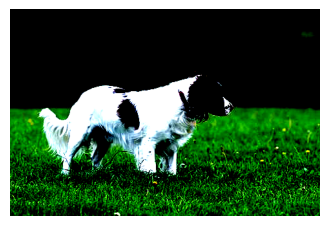

In [17]:
fig,ax=plt.subplots(figsize=(4,4))
t1=show_image(img[0],ax=ax)
#plt.close(fig)

In [18]:
show_image??

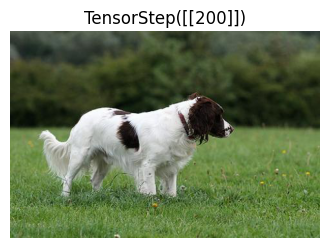

In [19]:
xy_dict=norm.decode(diff_tuple).show_each(show_noise=True)
xy_dict['x']

<AxesSubplot:title={'center':'TensorStep([[200]])'}>

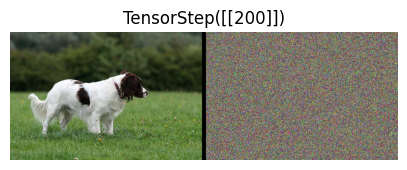

In [20]:
norm.decode(diff_tuple).show(show_noise=True)

Next, we need to go create a noised image, to pass to our model. 

First, how much noise to apply to each step?

In [21]:
#| export
class LinearNoiseSchedule:
    "Schedule like used in DDPM"
    def __init__(self,betas=None,n_steps=None,device='cuda'):
        if betas is not None: self.n_steps=betas.shape[0]
        if n_steps is None: self.n_steps=1000
        if betas is None: self.betas = torch.linspace(0.0001, 0.02, self.n_steps,device=device)
        self.alphas = 1. - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

Lets graph the various values here, in order to see what happens. Pay particularly close attention to `alpha_bar` as that controls the balance betwen our signal(image) and our noise. 

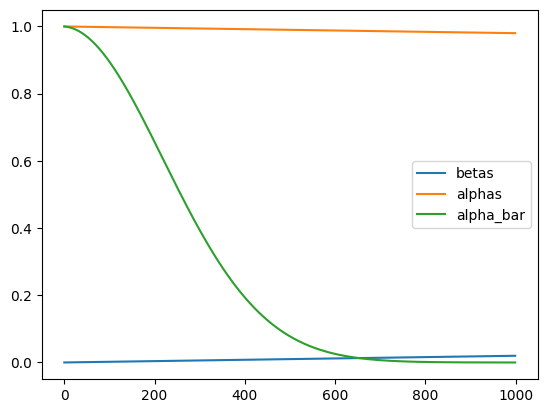

In [22]:
lns=LinearNoiseSchedule()
plt.plot((lns.betas).cpu())
plt.plot((lns.alphas).cpu())
plt.plot((lns.alpha_bar).cpu())
plt.legend(['betas', 'alphas','alpha_bar'])

Next is DDPM-style Q-sampling. This is pretty much used for all diffusion models, and is the process that takes us from and image to noise. 

In [23]:
#| export
class DDPM_Q_Sampling():
    def __init__(self,predicts_x=False,noise_schedule=LinearNoiseSchedule(),n_steps=1000,device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,len(self.ns.alpha_bar)-1,n_steps,dtype=torch.long)[...,None,None,None]
    def __call__(self,x,es,t):
        t=self.t_sched[t]
        a=self.ns.alpha_bar[t].to(device=x.device)
        signal = (a ** .5)*x
        noise = (1-a)**.5 * es
        return signal + noise
    def undo(self,z,es,t):
        "Goes back to the original image given noise. Only works if es is the original noise. If es is a TensorImage, assumes it is the original."
        if(isinstance(es,TensorImage)): 
            return es 
        t=self.t_sched[t]
        a=TensorBase(self.ns.alpha_bar[t].to(device=z.device))
        noise=TensorBase((1-a)**.5 * es)
        return TensorImage((z-noise)/(a ** .5))

In [24]:
#| export
#| echo: false
class DiffusionSamplingTransform(ItemTransform):
    order=101
    "noise_sampler, or q_sampler, goes to noise at t=T. image sampler, p_sampler, goes to image at t=0"
    def __init__(self,noise_sampler,image_sampler):
        self.q_sample=noise_sampler
        self.p_sample=image_sampler
    def encodes(self,xy:DiffusionTuple):
        xy.q_sample=self.q_sample
        xy.p_sample=self.p_sample
        y=xy.y
        ts = xy.t[:,0]
        noise=TensorBase(xy.y) if(isinstance(xy.y,TensorNoise)) else TensorBase(torch.randn_like(xy.y))
        x=self.q_sample(xy.x, noise,TensorBase(ts),)
        xy.x[:]=x[:]
        return xy
    def decodes(self,xy:DiffusionTuple):
        ts = type(xy.x)(xy.t)
        sampled_y = TensorImage(self.p_sample(xy.x.clone().detach().cuda(),xy.t.clone().detach().cuda(),y_type=type(xy.y)))
        x0 = TensorImage(self.q_sample.undo(xy.x.clone().detach().cuda(),xy.y.clone().detach().cuda(),xy.t[:,0].clone().detach().cuda()))
        return DiffusionTuple(xy.x,x0,*xy[1:],sampled_y)

In [25]:
diff_trans = DiffusionSamplingTransform(DDPM_Q_Sampling(),lambda x:x)

<AxesSubplot:title={'center':'TensorStep([[200]])'}>

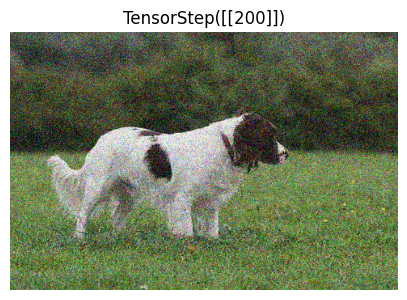

In [26]:
norm.decode(diff_trans(diff_tuple)).show()

Lets now test so make sure our noise is being generated correctly.

In [27]:
noise_tuple=LabelToNoise.encodes(DiffusionTuple(img[0].detach().clone(),TensorStep(torch.tensor([[999]])),TensorNoise(img[0].clone())))

<AxesSubplot:title={'center':'TensorStep([[999]])'}>

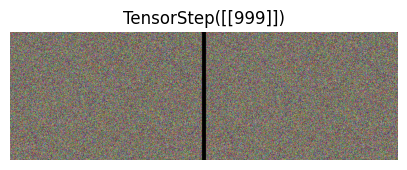

In [28]:
norm.decode(diff_trans(noise_tuple)).show(show_noise=True)

These are not exactly the same as it is one noising step, but they are fairly close. 

In [29]:
is_close(norm.decode(diff_trans(noise_tuple))[0],TensorImage(norm.decode(diff_trans(noise_tuple))[2]),eps=1e-02)

TensorImage(True, device='cuda:0')

### Going from noise to and image, p_sampling

P sampling is going from noise to image! 

In [30]:
#| export
class Diffusion_P_Sampler():
    def __init__(self,model,sampling_function):
        self.device=sampling_function.device
        self.model=model
        self.sampling_function=sampling_function
    # __call__ implemented, but not shown.
    def iter_noise(self,x_t,ts,t_start,y_type=TensorNoise):
        i=0
        while((ts>0).any()):
            x,t=x_t[ts>0],ts[ts>0]
            with autocast(device_type=self.device, dtype=x.dtype):
                with torch.no_grad(): 
                    e = y_type(self.model(x,self.deconvert(t) if i!=0 else t_start))
                x_t[ts>0]=self.sampling_function(x,e,t,t=t_start if i==0 else None)
            ts[ts>0]-=1
            i+=1
            yield x_t

In [31]:
#| export
#| echo: false
@patch
def __call__(self:Diffusion_P_Sampler,x,ts=None,y_type=TensorNoise):
    if ts is None: ts=(self.sampling_function.ns.n_steps-1)*torch.ones([x.shape[0],1],device=x.device,dtype=torch.long)
    t_start=TensorBase(ts.flatten())
    ts = self.sampling_function.convert(t_start)
    for xt in self.iter_noise(x,ts,t_start,y_type=TensorNoise): x=xt
    return x
@patch
def convert(self:Diffusion_P_Sampler,ns_t): return self.sampling_function.convert(ns_t)
@patch
def deconvert(self:Diffusion_P_Sampler,ns_t): return self.sampling_function.deconvert(ns_t)

In [32]:
#| export
#| echo: false
class DDPM_P_Sampling():
    def __init__(self,predicts_x=False,noise_schedule=LinearNoiseSchedule(),n_steps=1000,device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,len(self.ns.alpha_bar)-1,n_steps,dtype=torch.long)[...,None,None,None]
        if(predicts_x): raise NotImplementedError()
    def convert(self,ns_t): return ns_t
    def deconvert(self,ns_t): return self.t_sched[ns_t].to(device=ns_t.device).flatten()

Notice here that we generate noise as random numbers during our sampling process. This makes DDPM sampling a stocastic process. 

In [33]:
#| export
@patch
def __call__(self:DDPM_P_Sampling,x,es,ns_t,t=None):
    t= self.t_sched[ns_t] if(t is None) else t[...,None,None,None]
    n=torch.randn_like(x)
    e,a,b=self._noise_at_t(es,t),self.ns.alphas[t],self.ns.betas[t]
    signal = (x - e) / (a ** 0.5)
    noise = b**.5 * n
    return signal + noise
@patch
def _noise_at_t(self:DDPM_P_Sampling,es,t):
    eps_coef = (1 - self.ns.alphas[t]) / (1 - self.ns.alpha_bar[t]) ** .5 
    return eps_coef* es

We implement DDIM sampling here, as it drastically reduces sampling time from 1000 steps to 50. DDIM is also a deterministic sampler, meaning we do not have random numbers generated as part of our sampling process. Just generally helps us keep our sanity when trying to show our results. https://arxiv.org/abs/2010.02502

In [34]:
#| export
#| echo: false
class DDIM_P_Sampling():
    def __init__(self,n_steps=50,noise_schedule=LinearNoiseSchedule(),device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,self.ns.n_steps-1,n_steps,dtype=torch.long)
    def convert(self,ns_t): return ns_t*(self.n_steps-1)//self.ns.n_steps+1
    def deconvert(self,ns_t): return self.t_sched[ns_t].to(device=ns_t.device)

In [35]:
#| export
@patch
def __call__(self:DDIM_P_Sampling,z,es,ns_t,t=None):
    if(t is None): t=self.t_sched[ns_t]
    tp1=self.t_sched[ns_t-1]
    a,a_tp1=self.ns.alpha_bar[t][...,None,None,None],self.ns.alpha_bar[tp1][...,None,None,None]
    if isinstance(es,TensorImage): 
        import pdb;pdb.set_trace()
        xs=es
        es=(z - (a)**.5 * xs)/(1-a)**.5
    else: 
        es=TensorBase(es)
        xs=(z - (1-a)**.5 * TensorBase(es))/ (a ** .5)
    signal = a_tp1**.5*(xs) 
    noise = (1-a_tp1)**.5*es
    return signal + noise

In [36]:
#| export
#| echo: false
@typedispatch
def show_results(x:DiffusionTuple, y, samples, outs, ctxs=None, max_n=10, figsize=None,show_noise=False,**kwargs):
    title=DiffusionTuple(*[ x_ for x_ in x[:-1]],*[y_ for y_ in y[-2:]])
    title=[k for k in list(title.dict.keys()) if show_noise or not isinstance(title.dict[k],TensorNoise)]
    title='/'.join(title)
    if ctxs is None: ctxs = get_grid(min(len(x[0]), max_n), ncols=4, figsize=figsize, title=title)
    for i,ctx in enumerate(ctxs): 
        DiffusionTuple(*[ x_[i] for x_ in x[:-1]],*[y_[i] for y_ in y[-2:]]
                      ).show(ctx=ctx,show_noise=show_noise,**kwargs)
    return ctxs
@typedispatch
def show_batch(x:DiffusionTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None,show_noise=False, **kwargs):
    title='/'.join(k for k in x.dict.keys() if show_noise or not isinstance(x.dict[k],TensorNoise))
    if ctxs is None: ctxs = get_grid(3*min(len(x[0]), max_n), nrows=nrows, ncols=3, figsize=figsize, title=title)
    for i,ctx in enumerate(ctxs): DiffusionTuple(*[ x_[i] for x_ in x]).show(show_noise=show_noise,ctx=ctx)

### Training a model

In [37]:
path = untar_data(URLs.CIFAR)

In [38]:
class ArgId(nn.Module):
    def __init__(self,i):
        super().__init__()
        self.i=i
    def forward(self,*args):
        return args[self.i]

In [39]:
m=ArgId(0)

In [40]:
#| export
#| echo: false
class FlattenCallback(Callback):
    order=1 #after GatherPredsCallback
    def before_batch(self):
        self.xbo=self.xb
        self.learn.xb=(self.xb[0],self.xb[-1].view(self.xb[-1].shape[::2]),)
    def after_batch(self):
        self.learn.xb=self.xbo

/home/molly/miniconda3/envs/fastai/lib/python3.10/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


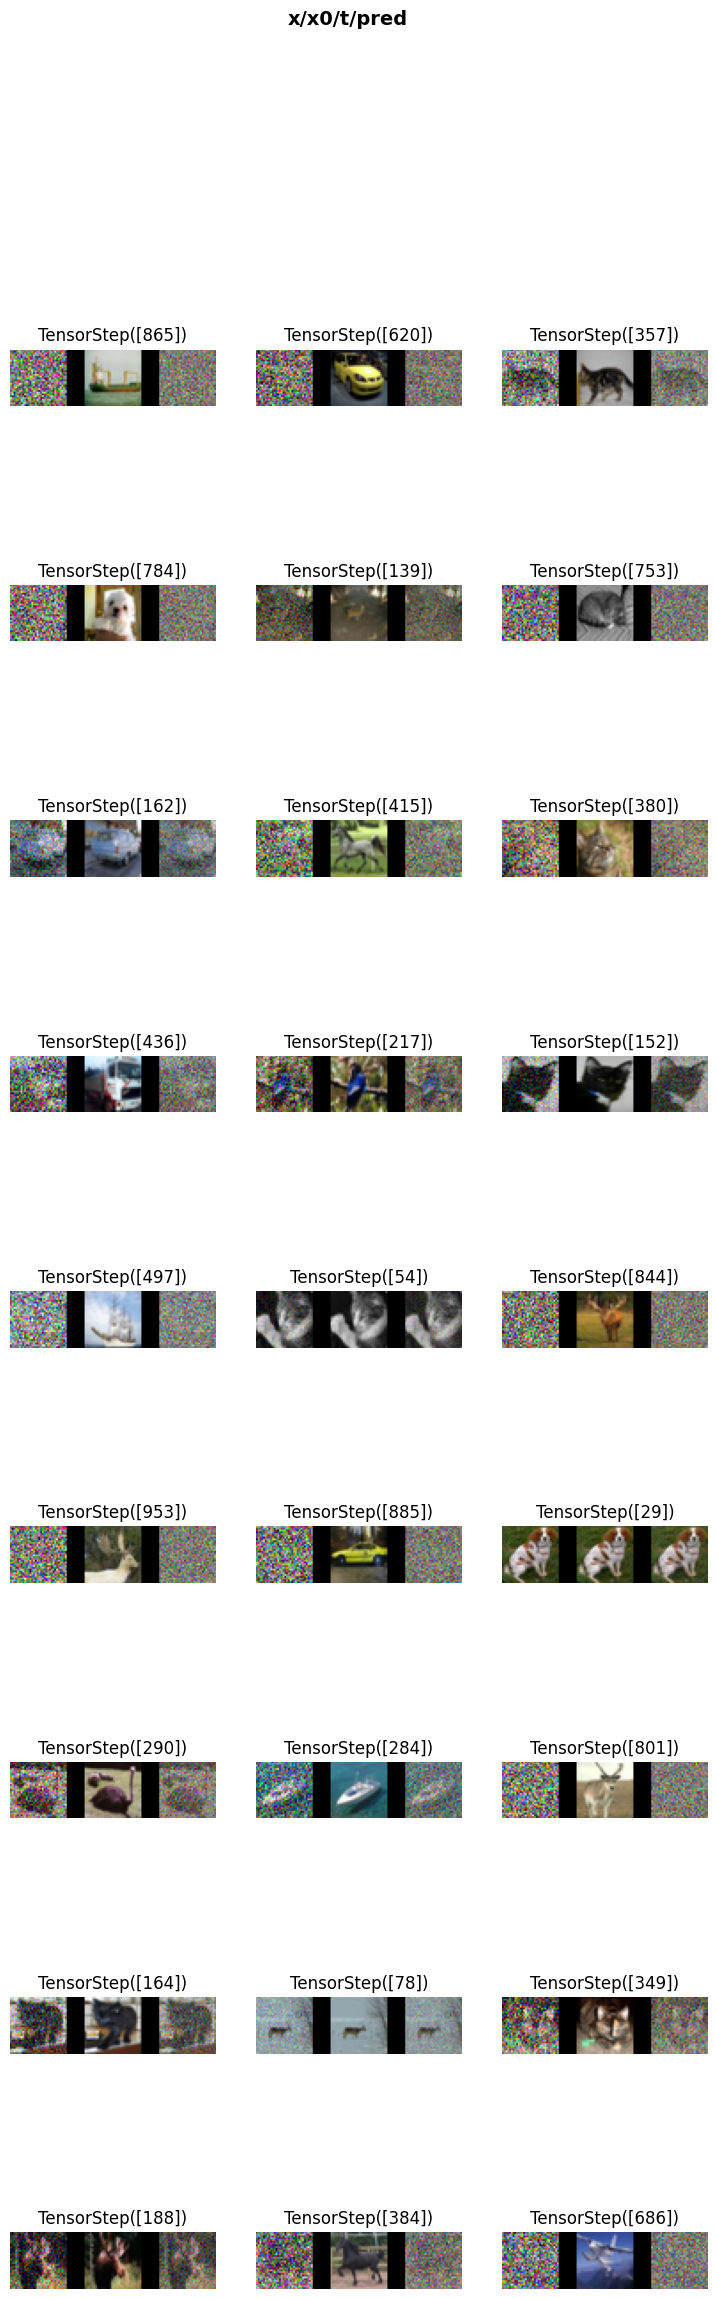

In [41]:
bs=128
n_steps=1000
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDIM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               TransformBlock(type_tfms=[Transform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=2,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,LabelToNoise,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

In [42]:
#| export
def mse_loss_weighted(ys,targ):
    return torch.mean(targ.w_sched[...,None] * ((ys - targ).flatten(start_dim=1) ** 2))

In [43]:
#| export
#| echo: true
def snr(at): return at/(1-at)

Taken from a paper called "Perception Prioritized Training of Diffusion Models, this is a continuous version of the weights. Which becomes our signal=to-noise ration, over the change in our signal to noise ratio. "https://arxiv.org/abs/2204.00227

In [44]:
#| export
def continuous_weights(at):
    weights = -snr(at[1:])/(snr(at[1:])-snr(at[:-1]))
    return torch.cat((weights[0:1],weights))

This is what the weights look like. Notice I clip the weights at 1. 

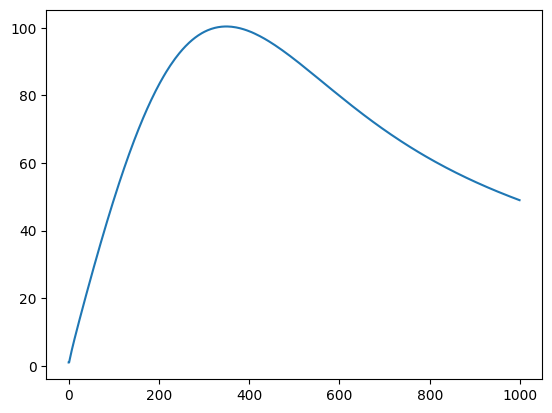

In [45]:
plt.plot(continuous_weights(LinearNoiseSchedule().alpha_bar).cpu().clip(min=1))

In [46]:
#| export
class WeightedLinSched(Callback):
    def after_pred(self):
        if(not hasattr(self,'ws')):
            self.ws = continuous_weights(LinearNoiseSchedule().alpha_bar).clip(min=1)
            self.ws /= self.ws.mean()
        ts=self.learn.xb[1].flatten()
        self.learn.yb[0].w_sched=self.ws[ts]

In [47]:
bs=128
n_steps=1000
m=Unet(dim=192+192//8,channels=3,).cuda()
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDIM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               TransformBlock(type_tfms=[Transform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=2,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,LabelToNoise,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)

In [48]:
learn = Learner(dls,m,mse_loss_weighted,opt_func=Adam,cbs=[FlattenCallback,WeightedLinSched])
learn = learn.to_fp16()
learn.fit_one_cycle(10,lr_max=2e-4,wd=1e-4)

next check show_results

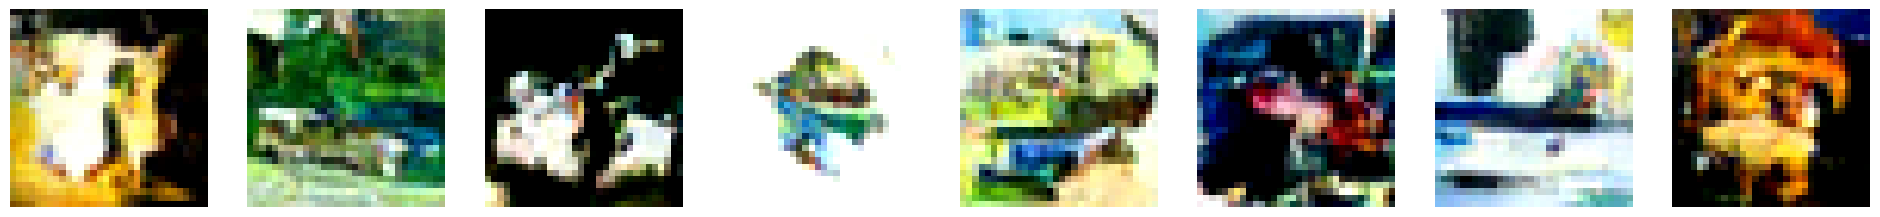

In [49]:
norm=Normalize.from_stats(*cifar_stats)
im=norm.decode(TensorImage(diffusion_transform.p_sample(torch.randn(8,3,32,32).cuda())))
show_images(im.clip(0,1))

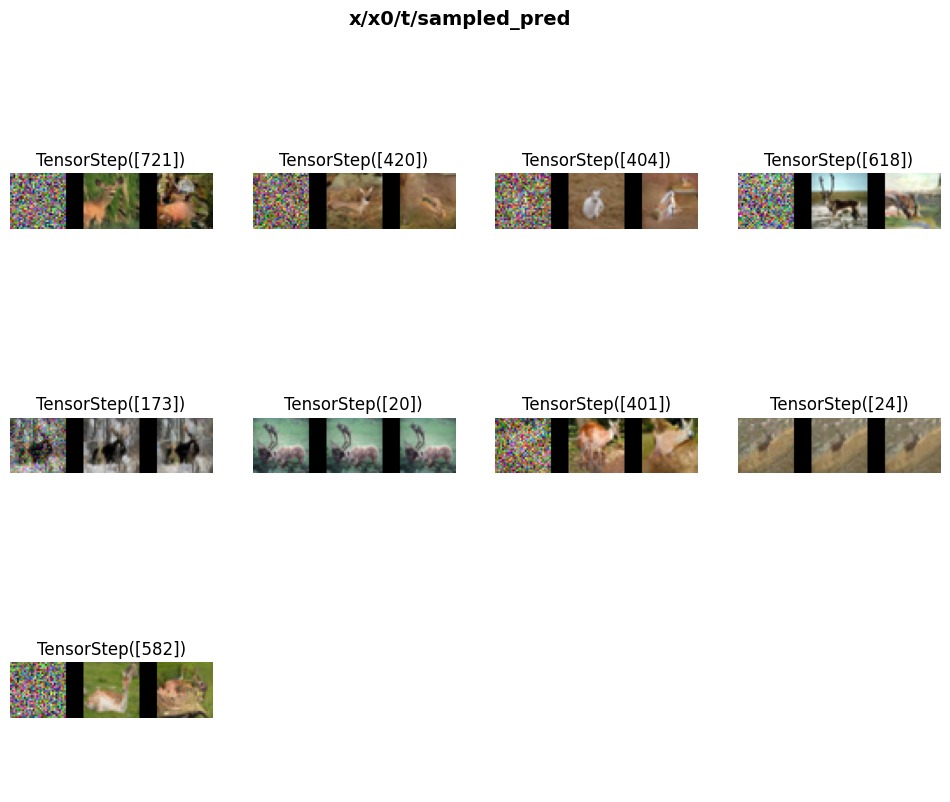

In [50]:
learn.show_results()

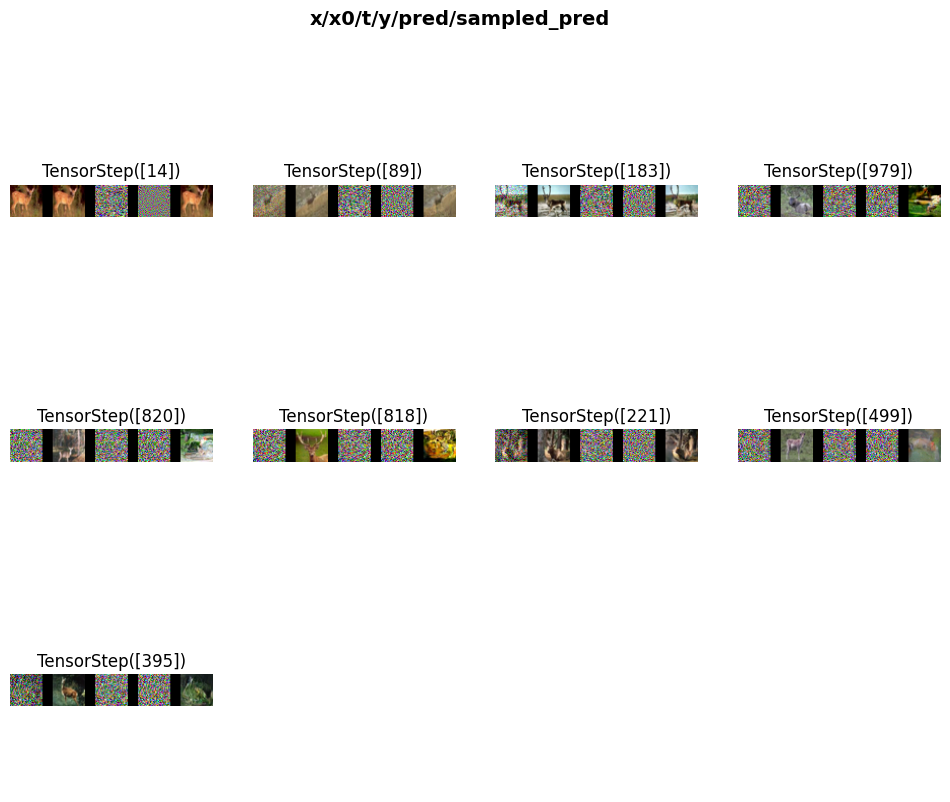

In [51]:
learn.show_results(show_noise=True)

In [52]:
del_if_exists('learn,m,dls,diffusion_transform')

In [53]:
bs=128
n_steps=1000
m=Unet(dim=192+192//8,channels=3,).cuda()
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDIM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               TransformBlock(type_tfms=[Transform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=2,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,LabelToNoise,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)

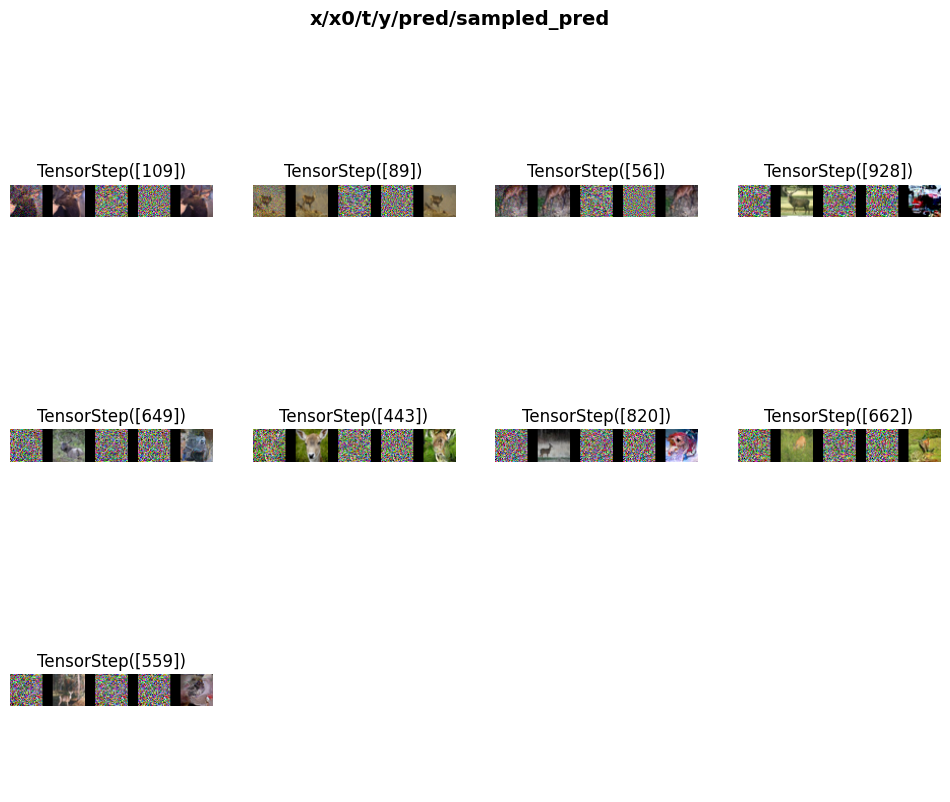

In [54]:
learn = Learner(dls,m,MSELossFlat(),opt_func=Adam,cbs=[FlattenCallback,WeightedLinSched])
learn = learn.to_fp16()
learn.fit_one_cycle(10,lr_max=2e-4,wd=1e-4)
learn.show_results(show_noise=True)

In [55]:
del_if_exists('learn,m,dls')

channels last, fused optimizers(foreach benjamin's), jit model.  

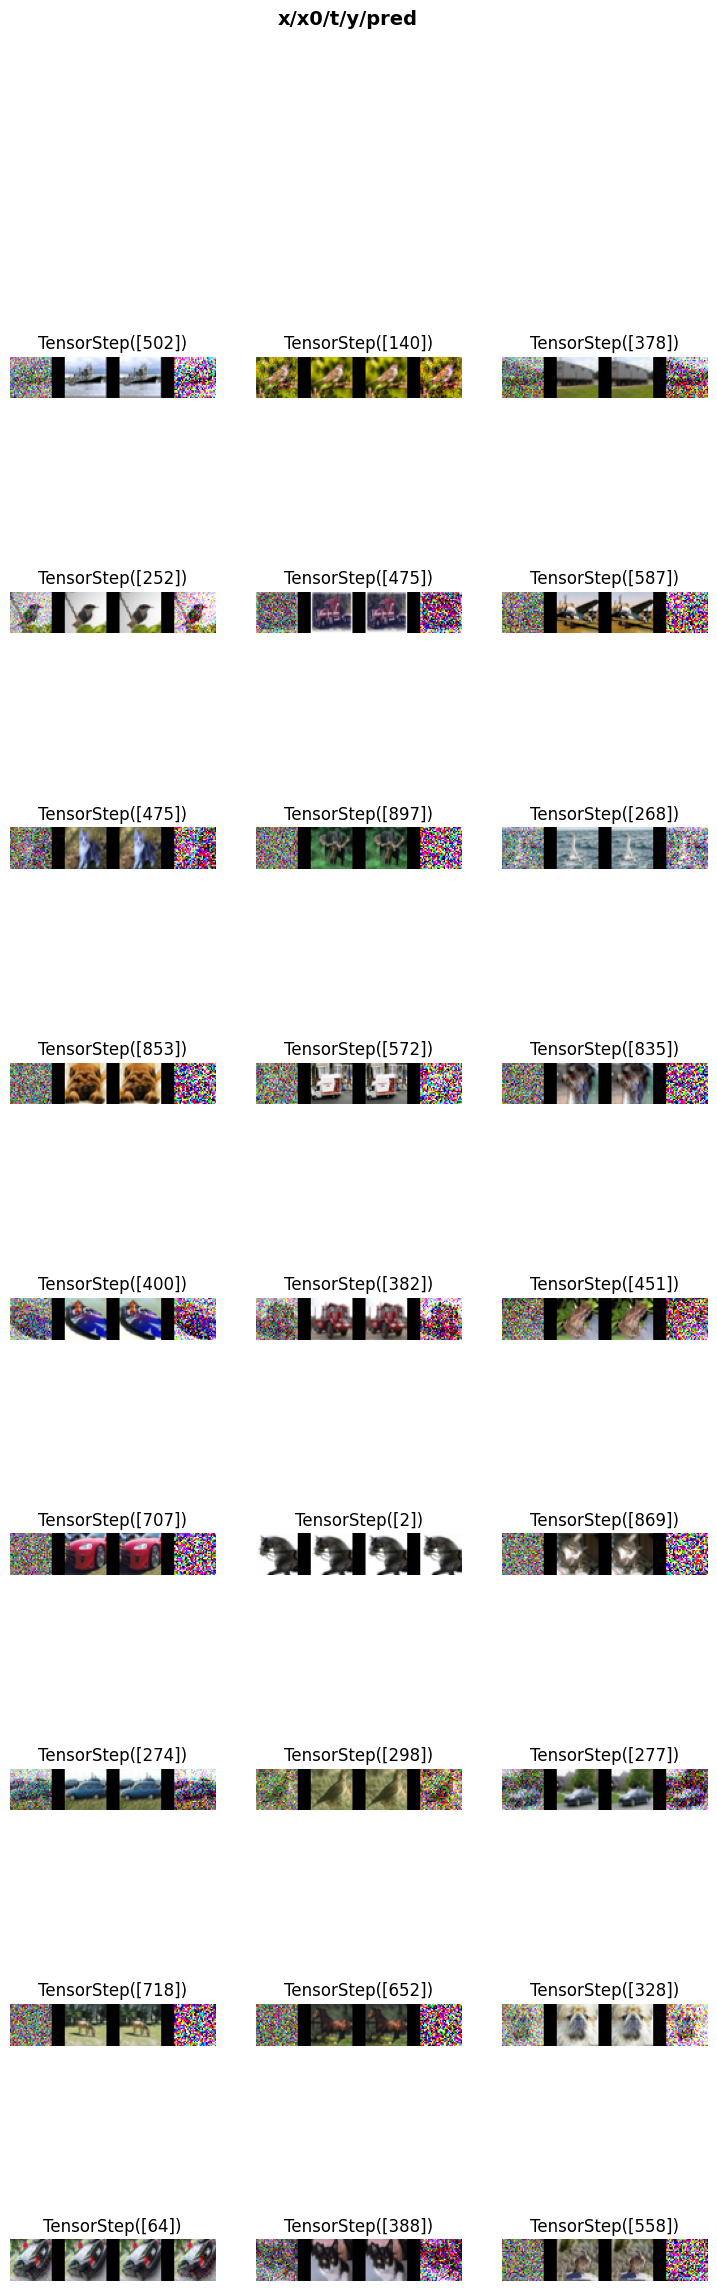

In [56]:
bs=128
n_steps=1000
m=Unet(dim=192+192//8,channels=3,).cuda()
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDIM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               TransformBlock(type_tfms=[Transform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=2,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

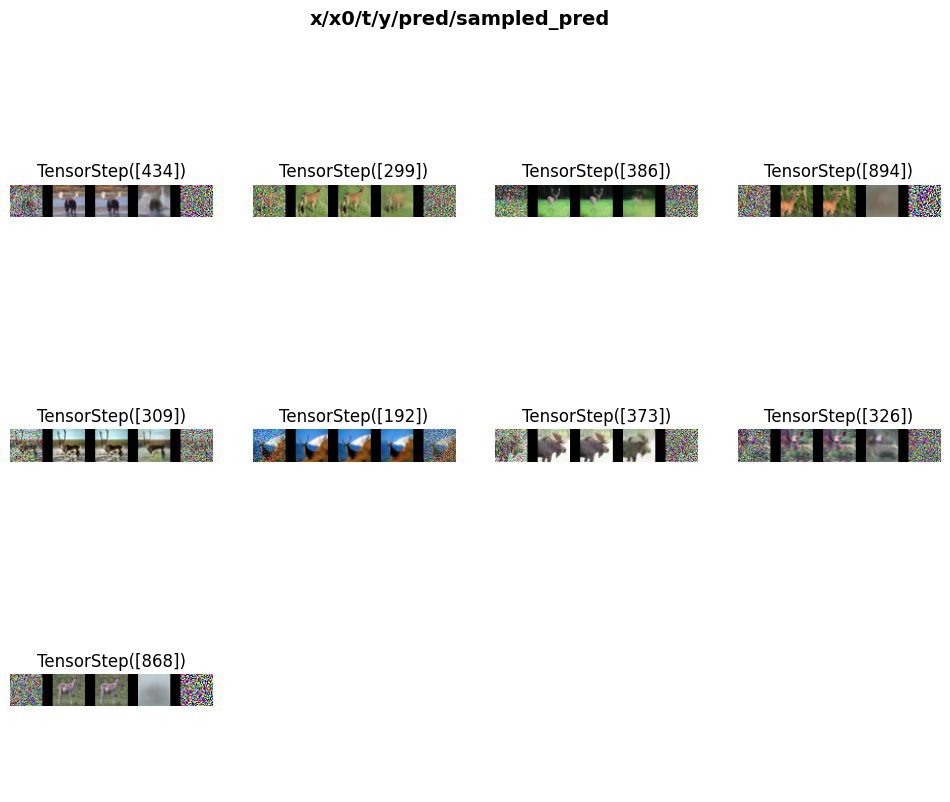

In [57]:
learn = Learner(dls,m,MSELossFlat(),opt_func=Adam,cbs=[FlattenCallback])
learn = learn.to_fp16()
learn.fit_one_cycle(10,lr_max=2e-4,wd=1e-4)
learn.show_results()

@typedispatch
def show_results(x:DiffusionTuple, y, samples, outs, ctxs=None, max_n=10, figsize=None,show_noise=False,**kwargs):
    title=DiffusionTuple(*[ x_ for x_ in x[:-1]],*[y_ for y_ in y[-2:]])
    title=[k for k in list(title.dict.keys()) if show_noise or not isinstance(title.dict[k],TensorNoise)]
    title='/'.join(title)
    if ctxs is None: ctxs = get_grid(min(len(x[0]), max_n), ncols=4, figsize=figsize, title=title)
    for i,ctx in enumerate(ctxs): 
        DiffusionTuple(*[ x_[i] for x_ in x[:-1]],*[y_[i] for y_ in y[-2:]]
                      ).show(ctx=ctx,show_noise=show_noise,**kwargs)
    return ctxs

@typedispatch
def show_results(x:DiffusionTuple, y, samples, outs, ctxs=None, max_n=10, figsize=None,show_noise=False,**kwargs):
    title=DiffusionTuple(*[ x_ for x_ in x[:-1]],*[y_ for y_ in y[-2:]])
    title=[k for k in list(title.dict.keys()) if show_noise or not isinstance(title.dict[k],TensorNoise)]
    title='/'.join(title)
    if ctxs is None: ctxs = get_grid(min(len(x[0]), max_n), ncols=4, figsize=figsize, title=title)
    for i,ctx in enumerate(ctxs): 
        DiffusionTuple(*[ x_[i] for x_ in x[:-1]],*[y_[i] for y_ in y[-2:]]
                      ).show(ctx=ctx,show_noise=show_noise,**kwargs)
    return ctxs

In [58]:
from fastai.callback.wandb import *

In [59]:
@typedispatch
def wandb_process(x:DiffusionTuple, y, samples, outs, preds):
    "Process `sample` and `out` depending on the type of `x/y`"
    res_out=None
    for i in range(len(x[0])): 
        res=DiffusionTuple(*[ x_[i] for x_ in x[:-1]],*[y_[i] for y_ in y[-2:]]
                      ).show_each(show_noise=True)
        res={k:wandb.Image(fig) for k,fig in res.items()}
        if res_out is None: res_out={k:[v] for k,v in res.items()}
        else: 
            for k,v in res.items(): res_out[k]+=[v]
    return res_out

In [60]:
del_if_exists('learn,m,dls')

In [61]:
import wandb
wandb.init(reinit=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marii. Use `wandb login --relogin` to force relogin


/home/molly/miniconda3/envs/fastai/lib/python3.10/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


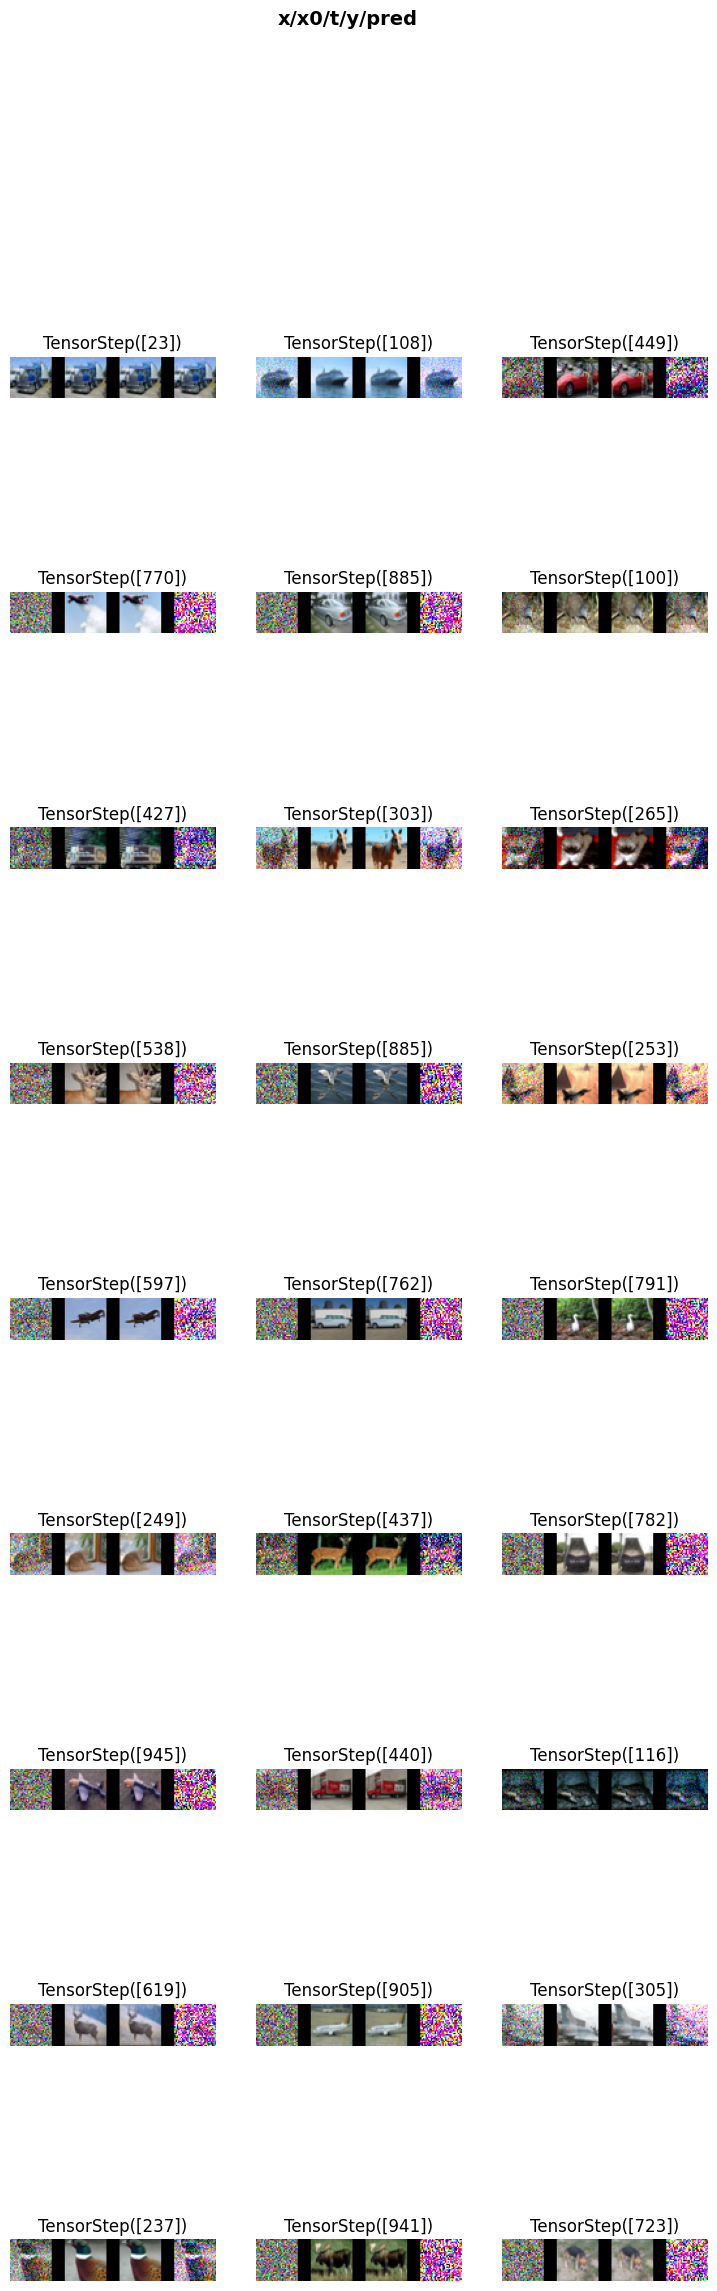

In [62]:
bs=128
n_steps=1000
m=Unet(dim=192+192//8,channels=3,).cuda()
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDIM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               TransformBlock(type_tfms=[Transform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=2,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

use foreach ADAM to go faster!!! 

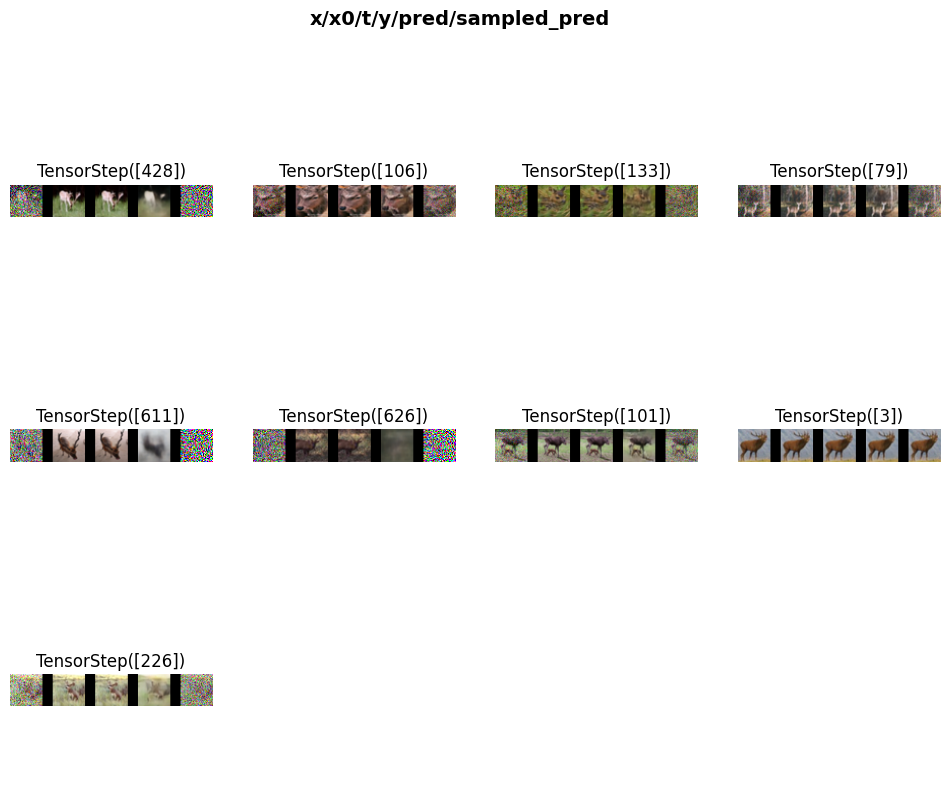

In [63]:
learn = Learner(dls,m,MSELossFlat(),opt_func=Adam,cbs=[FlattenCallback,WandbCallback(log_preds_every_epoch=True)])
learn = learn.to_fp16()
learn.fit_one_cycle(10,lr_max=2e-4,wd=1e-4)
learn.show_results()

In [3]:
#|hide
from nbdev.export import nb_export
nb_export('Refactor.ipynb','../../lib/blogdiffusion')